#### Prerequisites
- To mitigate configuration and permission issues, refer to the provided blog links for step-by-step instructions on setting up the Sagemaker domain and Opensearch cluster:https://aws.amazon.com/blogs/machine-learning/implement-unified-text-and-image-search-with-a-clip-model-using-amazon-sagemaker-and-amazon-opensearch-service/
- The dataset preparation can be done by referring to the following links:https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/image-search/Image_Search-multilingual.ipynb

Install some python packages we are going to use

In [ ]:
%pip install -qU aiobotocore 
%pip install -q jsonlines
%pip install -q requests_aws4auth
%pip install -q elasticsearch==7.13.4

Import required libraries and packages we are going to use

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os
import sagemaker
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

%matplotlib inline

In [ ]:
s3_bucket_name = sagemaker.session.Session().default_bucket()

#### Model Preparation

The original blog's rn50 model should be replaced with ViT-B-32

You are going to create a SageMaker model from a pretrained CLIP model. The first step is to download a pretrained model weighting files, put it into a model.tar.gz file and upload the file to S3.The path of pretrained model can be found in[CLIP Repo](https://github.com/openai/CLIP/blob/main/clip/clip.py#L30)

In [ ]:
%%writefile build_model_tar.sh
#!/bin/bash
BUCKET_NAME="$1"
MODEL_NAME=ViT-B-32.pt
MODEL_NAME_URL=https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt

BUILD_ROOT=/tmp/model_path
S3_PATH=s3://${BUCKET_NAME}/models/clip/model.tar.gz


rm -rf $BUILD_ROOT
mkdir $BUILD_ROOT
cd $BUILD_ROOT && curl -o $BUILD_ROOT/$MODEL_NAME $MODEL_NAME_URL
cd $BUILD_ROOT && tar -czvf model.tar.gz .
aws s3 cp $BUILD_ROOT/model.tar.gz  $S3_PATH

The bash script in the preceding cell should be executed.

In [ ]:
!bash build_model_tar.sh {s3_bucket_name}

You should be able to see the model tar file exists in Amazon S3.

In [ ]:
!aws s3 ls s3://{s3_bucket_name}/models/clip/model.tar.gz

Then you need to provide inference code for the CLIP model. CLIP uses PyTorch for its implementation, so we are going to use SageMaker PyTorch framework. More information related to deploy an PyTorch model with SageMaker can be found [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-pytorch-models). The inference code accepts two environment variables MODEL_NAME and ENCODE_TYPE. MODEL_NAME helps us to switch between different CLIP model easily. ENCODE_TYPE is to specify if you want to encode an image or a piece of text. Here, we implement the model_fn, input_fn, predict_fn and output_fn function to override the [default PyTorch inference handler](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py).

In [ ]:
!mkdir -p code

In [ ]:
%%writefile code/clip_inference.py

import io
import torch
import clip
from PIL import Image
import json
import logging
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MODEL_NAME = os.environ.get("MODEL_NAME", "ViT-B-32.pt")
ENCODE_TYPE = os.environ.get("ENCODE_TYPE", "TEXT")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# defining model and loading weights to it.
def model_fn(model_dir):
    model, preprocess = clip.load("ViT-B/32", device=device)
    return {"model_obj": model, "preprocess_fn": preprocess}

def load_from_bytearray(request_body):
    return image

# data loading
def input_fn(request_body, request_content_type):
    assert request_content_type in (
        "application/json",
        "application/x-image",
    ), f"{request_content_type} is an unknown type."
    if request_content_type == "application/json":
        data = json.loads(request_body)["inputs"]
    elif request_content_type == "application/x-image":
        image_as_bytes = io.BytesIO(request_body)
        data = Image.open(image_as_bytes)
    return data

# inference
def predict_fn(input_object, model):
    model_obj = model["model_obj"]
    preprocess_fn = model["preprocess_fn"]
    assert ENCODE_TYPE in ("TEXT", "IMAGE"), f"{ENCODE_TYPE} is an unknown encode type."
    if ENCODE_TYPE == "TEXT":
        input_ = clip.tokenize(input_object).to(device)
    elif ENCODE_TYPE == "IMAGE":
        input_ = preprocess_fn(input_object).unsqueeze(0).to(device)
    # inference
    with torch.no_grad():
        if ENCODE_TYPE == "TEXT":
            prediction = model_obj.encode_text(input_)
        elif ENCODE_TYPE == "IMAGE":
            prediction = model_obj.encode_image(input_)
    return prediction

# Serialize the prediction result into the desired response content type
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

Specify the appropriate requirements.txt file to enable SageMaker to install supplementary packages during model hosting.

In [ ]:
%%writefile code/requirements.txt
ftfy
regex
tqdm
git+https://github.com/openai/CLIP.git

The PyTorchModel class is utilized to create an object that encompasses the S3 location information for the model and details regarding the inference entry point. We have established Clip_image_model for encoding images and Clip_text_model for encoding text, respectively.

from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session


role = get_execution_role()
shared_params = dict(
    entry_point="clip_inference.py",
    source_dir="code",
    role=role,
    model_data=f"s3://{s3_bucket_name}/models/clip/model.tar.gz",
    framework_version="1.9.0",
    py_version="py38",
)

clip_image_model = PyTorchModel(
    env={'MODEL_NAME': 'ViT-B-32.pt', "ENCODE_TYPE": "IMAGE"},
    name="clip-image-model1",
    **shared_params
)

clip_text_model = PyTorchModel(
    env={'MODEL_NAME': 'ViT-B-32.pt', "ENCODE_TYPE": "TEXT"},
    name="clip-text-model1",
    **shared_params
)

#### The Sagemaker terminal nodes should be deployed for real-time inference

In [ ]:
text_predictor = clip_text_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=True
)

image_predictor = clip_image_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=IdentitySerializer(content_type="application/x-image"),
    deserializer=JSONDeserializer(),
    wait=True
)

#### The implementation of image batch processing can be achieved by utilizing Sagemaker transform job

In [ ]:
from multiprocessing.pool import ThreadPool
import boto3
import tqdm.notebook as tq
from urllib.parse import urlparse

s3_sample_image_root = f"s3://{s3_bucket_name}/sample-images"

client = boto3.client('s3')


batch_input = s3_sample_image_root + "/"
output_path = f"s3://{s3_bucket_name}/inference/clip-search/output/"

clip_image_transformer = clip_image_model.transformer(
    instance_count=1,
    instance_type="ml.c5.xlarge",
    strategy="SingleRecord",
    assemble_with="Line",
    output_path=output_path,
)

clip_image_transformer.transform(
    batch_input, 
    data_type="S3Prefix",
    content_type="application/x-image", 
    wait=True,
    logs=False
)

In [ ]:
#！aws s3 sync s3:{s3_bucket_name}/inference/clip-search/output/ ./embedding

#This above instruction guide you on how to download embeeding from s3 to your local computer.

#### Load OpenSearch Service

Next we will define the opensearch_region and opensearch_url, we will use our CloudFormation Stack Name to fetch the OpenSearch Domain URL.

Note1 If you didn't use the CloudFormation template provided in the repo to create the cluster. You can skip the following cell and define your own opensearch_region and opensearch_region.
Note2 If your SageMaker Execution role doesn't have permission to describe CloudFormation Stack. You can go the CloudFormation service in AWS Console, and use the output of clip-poc-stack to config these two parameters.

In [ ]:
import boto3

client = boto3.client('cloudformation')

response = client.describe_stacks(
    StackName='clip-poc-stack',
)

my_session = boto3.session.Session()

opensearch_region = my_session.region_name
opensearch_url = [
    output_["OutputValue"]
    for output_ in response["Stacks"][0]["Outputs"]
    if output_["OutputKey"] == "DomainEndpoint"
][0]

#### Setting up the Amazon OpenSearch Service domain using KNN settings

First, set up an OpenSearch service cluster. For instructions, see [Creating and Managing Amazon OpenSearch Service Domains](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/createupdatedomains.html).
Once the OpenSearch cluster is set up, create an index to store the item meta data and the embeddings. The index settings must be configured beforehand to enable the KNN functionality using the following configuration:

In [ ]:
index_settings = {
  "settings": {
    "index.knn": True,
    "index.knn.space_type": "cosinesimil"
  },
  "mappings": {
    "properties": {
      "embeddings": {
        "type": "knn_vector",
        "dimension": 512 
      }
    }
  }
}

In [ ]:
import boto3
import json
from requests_aws4auth import AWS4Auth
from elasticsearch import Elasticsearch, RequestsHttpConnection


index_name = "clip-index-newest"

def get_es_client(host=opensearch_url,
    port=443,
    region=opensearch_region,
    index_name=index_name
):

    credentials = boto3.Session().get_credentials()
    awsauth = AWS4Auth(credentials.access_key,
                       credentials.secret_key,
                       region,
                       'es',
                       session_token=credentials.token)

    headers = {"Content-Type": "application/json"}

    es = Elasticsearch(hosts=[{'host': host, 'port': port}],
                       http_auth=awsauth,
                       use_ssl=True,
                       verify_certs=True,
                       connection_class=RequestsHttpConnection,
                       timeout=60 # for connection timeout errors
    )
    return es
es = get_es_client()
#If you possess an index, it can be generated through the utilization of the downlink code; however, if you already possess an index, please annotate and disable the downlink code  
#es.indices.create(index=index_name, body=json.dumps(index_settings))

You can check if the index is created within your es cluster

In [ ]:
print(es.indices.get_alias("*"))

In [ ]:
# The embedding is being loaded into opensearch
for item in files:
    embedding_file = f"{embedding_root_path}/{item}"
    name, ext = os.path.splitext(item)
    print(name)
    vector=json.load(open(embedding_file))[0]
    es.index(index=index_name,
             #id=name_result,
             #doc_type='_doc',
             body={'embeddings': vector,
                   "image_name": name}
            )

Now that you have a working OpenSearch index to contain embeddings for your inventory, let's have a look at how you can generate embedding for new items. You need to create two Amazon SageMaker endpoint for extracting text features and image features. [Amazon SageMaker Serverless Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html) is a purpose-built inference option that makes it easy for you to deploy and scale ML models. Serverless Inference is ideal for workloads which have idle periods between traffic spurts and can tolerate cold starts. Since you are creating a POC search engine, Serverless Inference is helpful to prevent extra cost.

#### Generate embeddings from the query

In [ ]:
import boto3
import json

# Create a low-level client representing Amazon SageMaker Runtime
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name='us-west-2')

def encode_image(file_name="./data/images/Screenshosdfsafagsfd.jpg"):    
    with open(file_name, "rb") as f:
        payload = f.read()
        print(payload)
        payload = bytearray(payload)
    #res = image_predictor.predict(payload)
    res = sagemaker_runtime.invoke_endpoint(
                        EndpointName = "clip-image-model1-2023-07-10-08-59-46-325",
                        ContentType  = "application/x-image",
                        Body         = payload)
    res_final=json.loads((res['Body'].read()))
    
    return res_final[0]

def encode_name(item_name):
    payload={"inputs": f"{item_name}"}
    payload_data=json.dumps(payload).encode('utf-8')
    res = sagemaker_runtime.invoke_endpoint(
                        EndpointName = "clip-text-model1-2023-07-10-08-56-15-444",
                        ContentType  = "application/json",
                        Body         = bytes(payload_data))
    res_final=json.loads((res['Body'].read()))
    return res_final[0]

In [ ]:
feature_vector_text1 = encode_name("Two dogs playing in the snow")

#### Make a k-nn based query

Let’s take a look at the results of a simple query. After retrieving results from the OpenSearch service, we get the item names and images from dataset.

In [ ]:
es = get_es_client()

In [ ]:
from PIL.Image import Image as PilImage
def search_products(embedding, k = 3):
    body = {
        "size": k,
        "_source": {
            "exclude": ["embeddings"],
        },
        "query": {
            "knn": {
                "embeddings": {
                    "vector": embedding,
                    "k": k,
                }
            }
        },
    }        
    res = es.search(index=index_name, body=body)
    print(res)
    
    images = []
    for hit in res["hits"]["hits"]:
        #id_ = hit["_id"]
        img = hit["_source"]["image_name"]
        #image, item_name = get_image_from_item_id(id_)
        #image.name_and_score = f'{hit["_score"]}:{item_name}'
        images.append(img)
    return images
    
images = search_products(feature_vector_text1)
print(images)

In [ ]:
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage
import os

for img in images:
    print(img)
    #im = Image.open(f"../sentence-transformers/examples/applications/image-search/photos/{img}")
    display(IPImage(os.path.join("../sentence-transformers/examples/applications/image-search/photos/", img), width=200))

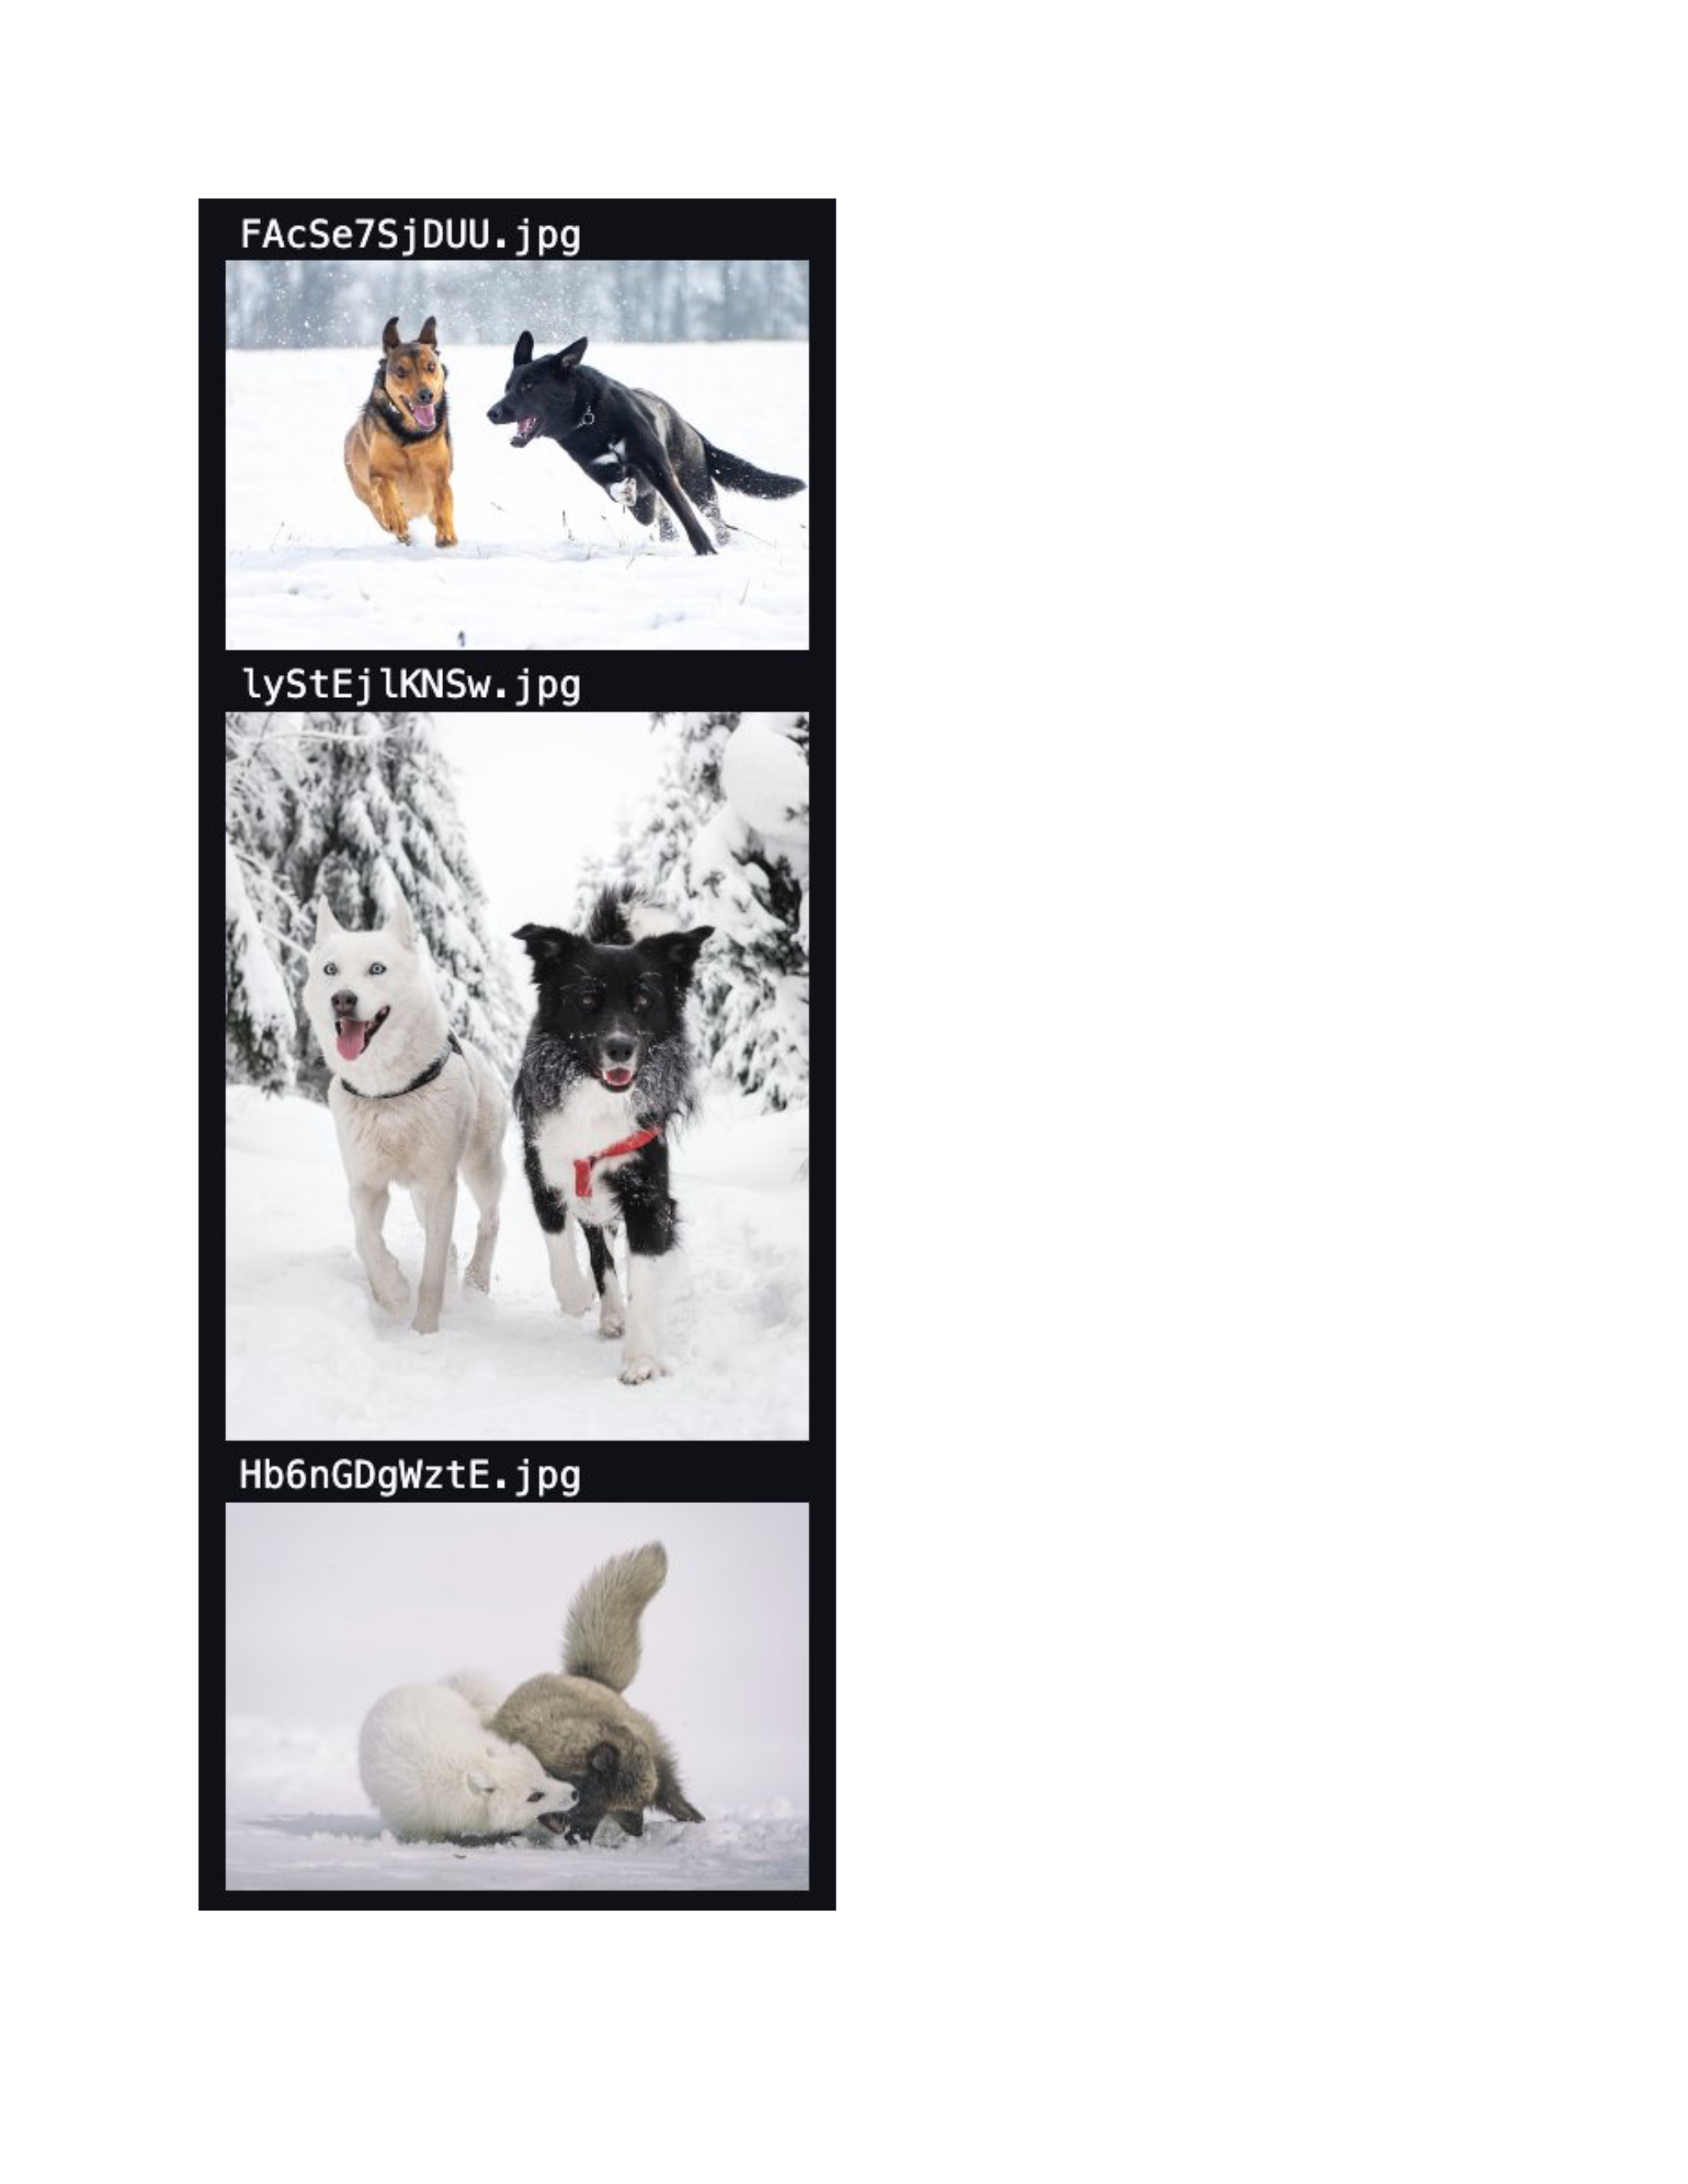